<a href="https://colab.research.google.com/github/yajima-yasutoshi/DataScience2025/blob/main/20260106/%E3%83%8F%E3%82%A4%E3%83%91%E3%83%BC%E3%83%91%E3%83%A9%E3%83%A1%E3%83%BC%E3%82%BF%E3%83%81%E3%83%A5%E3%83%BC%E3%83%8B%E3%83%B3%E3%82%B0%E5%B0%8F%E3%83%86%E3%82%B9%E3%83%88%E8%A7%A3%E7%AD%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ハイパーパラメータチューニング

#本日の講義の目的

回帰や分類などの予測モデル構築で、
予測精度を向上させるテクニックとして良く知られた
**正則化パラメータチューニング**について説明する。
なお、これは一般的に
**ハイパーパラメータチューニング**
と呼ばれるものの一つであり、
機械学習モデルの精度向上には欠かせないテクニックである。


## 環境の準備
以下のコードセルを実行し、
日本語の表示を行うための設定と分析に必要なパッケージのインポートを行う。

In [1]:
# 日本語環境のインストール
!pip install japanize-matplotlib

# 必要なライブラリをインポート
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

# 分析に必要なライブラリのインポート
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 回帰に必要なライブラリをインポート
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

# 分類（ロジスティック回帰）に必要なライブラリー
from sklearn.linear_model import LogisticRegression

# 精度評価に必要なライブラリー
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# その他必要なライブラリー
from sklearn.model_selection import GridSearchCV

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 34.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=7d3a4021489d555c0999f1b66e69f4b100a48bca61bb96f0da6e82f15f06d23f
  Stored in directory: /root/.cache/pip/wheels/c1/f7/9b/418f19a7b9340fc16e071e89efc379aca68d40238b258df53d
Successfully built japanize-matplotlib



---
---
---

# ロジスティック回帰でのハイパーパラメータチューニング




## Titanic データの読み込み

以下のコードセルを実行することで、
seaborn パッケージに含まれているデモデータの一つである、
Titanic データを読み込む。

In [3]:
# データを読み込む
# 変数名を data とした
data = sns.load_dataset('titanic') #タイタニックのデータ

###データの構造の確認

info を使い、データの構造を確認する。

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


レコード数は891、項目数は15、欠損値を含む列も複数あることが分かる。

In [5]:
data.head(5)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


##データの説明と分析の目的

このデータは、
1912年に発生したタイタニック号の沈没事故の乗客情報のデータである。
各項目の意味は以下の通りである。

列名 | 型 | 意味
---  | --- | --
survived	| カテゴリ | 生存フラグ（0=死亡、1=生存）
pclass	|  カテゴリ |チケットクラス（1stクラス、2ndクラス、3rdクラス）＊classと同じ内容のため用いない
sex	|  カテゴリ |性別（male：男性、female：女性）
sge	|  数値 |年齢
sibsp	|  数値 |タイタニックに同乗している兄弟/配偶者の数
parch	|  数値 |タイタニックに同乗している親/子供の数
fare	|  数値 |料金
embarked	|  カテゴリ |出港地（タイタニックへ乗った港）(C=Cherbourg、Q=Queenstown、S=Southampton)
class |  カテゴリ |乗船クラス
who | カテゴリ |男性 or 女性
adult_male |  カテゴリ |成人男性であるかどうか
deck |  カテゴリ |乗船していたデッキ
embark_town |  カテゴリ |出港地 ＊embarked と同じ内容のため用いない
alive |  カテゴリ |生存したかどうか ＊survived と同じ内容ため用いない
alone |  カテゴリ |一人であったかどうか


このデータを学習用データとして用い、
**乗客の生存を予測するAIモデル**を作成する。

In [6]:
data['pclass'].value_counts()

,count
pclass,
3,491
1,216
2,184


## 前処理
欠損値の確認を行う。

In [7]:
# 欠損値を確認する
data.isnull().sum()

,0
survived,0
pclass,0
sex,0
age,177
sibsp,0
parch,0
fare,0
embarked,2
class,0
who,0


In [8]:
data.shape[0] - 688

203

上の結果より、
このデータには age, embarked, deck などに欠損値が含まれていることがわかる。

age は数値型の項目であることから、欠損した部分を平均値で埋めることにする。
また embarked はカテゴリ型の項目であることから、
最頻値を使い欠損値を埋めることとする。

さらに、deck は欠損値が多数あるため、説明変数としては用いないこととする。


In [9]:
# age, embarked, の欠損値を埋める。
# deck は欠損値が多数あるため説明変数には用いないことにする。

# age は数値型なので、平均値で欠損値を埋める。
data['age'] = data['age'].fillna(data['age'].mean())

# カテゴリ型の項目は、最頻値で欠損値を埋める。
data['embarked'] = data['embarked'].fillna(data['embarked'].mode()[0])
data['embark_town'] = data['embark_town'].fillna(data['embark_town'].mode()[0])

# 結果を確認
data.isnull().sum()

,0
survived,0
pclass,0
sex,0
age,0
sibsp,0
parch,0
fare,0
embarked,0
class,0
who,0


In [10]:
data.shape[0] - 688

203

## 基礎集計

どのような属性の乗客が生存率が高いのか（低いのか）を調べるため、
基礎集計として以下のコードセルを実行する。
なお、それぞれの結果を表示させるため print() を付与している。

In [11]:
# 表示する桁数を指定
# pd.options.display.float_format = '{:.2f}'.format

# 全体の概要の確認
print("\n項目")
print( data.info() )


# 基本的な統計情報を表示
print("\n数値型の項目に対する統計量の表示")
print( data.describe() )

# 目的変数の確認（生存者数と死亡者数を集計）
survived_counts = data['survived'].value_counts()
print("\n生存者数と死亡者数の集計:")
print(survived_counts)

# 乗客のクラスごとの生存率を計算
survival_rate_by_class = data.groupby('class')['survived'].mean()
print("\nクラスごとの生存率:")
print(survival_rate_by_class)

# 性別ごとの生存率を計算
survival_rate_by_gender = data.groupby('sex')['survived'].mean()
print("\n性別ごとの生存率:")
print(survival_rate_by_gender)


項目
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          891 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     891 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  891 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB
None

数値型の項目に対する統計量の表示
         survived      pclass         age       sibs

/tmp/ipython-input-1798172899.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  survival_rate_by_class = data.groupby('class')['survived'].mean()


In [12]:
data['pclass'].value_counts()

,count
pclass,
3,491
1,216
2,184


In [13]:
data['sex'].value_counts()

,count
sex,
male,577
female,314


In [14]:
data.groupby('class')['survived'].sum()

/tmp/ipython-input-3354869005.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby('class')['survived'].sum()


,survived
class,
First,136
Second,87
Third,119


In [15]:
data[ (data['class']=='First') & (data['survived'] == 1)].shape

(136, 15)

In [16]:
data[ (data['class']=='Third') & (data['survived'] == 1)].shape

(119, 15)

## ロジスティック回帰モデルの構築

まず、数値型の項目のみでモデルを作成し精度を確認する。

In [17]:
# 説明変数と目的変数を選択
# 数値データのみで予測
X = data[[ 'age', 'fare', 'sibsp', 'parch']]
y = data[['survived']]

In [18]:
# データを学習用と検証用に分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 説明変数の標準化の準備
scaler = StandardScaler()
scaler.fit(X_train)

# 標準化後のものは別の変数にセットすると良い
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

# ロジスティック回帰モデルの準備
model = LogisticRegression()

# モデルを訓練
model.fit(X_train_scaled, y_train.values.ravel()  )

# テストデータで予測
y_pred = model.predict(X_val_scaled)

# 精度を計算
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.6815642458100558


### 回帰係数

回帰係数の正負は、以下の意味合いがある。

* 回帰係数が正：大きいほど 1 （生存） になりやすい。（小さいほど0になりやすい）
* 回帰係数が負：大きいほど 0 （死亡） になりやすい。（小さいほど1になりやすい）

<Axes: ylabel='None'>

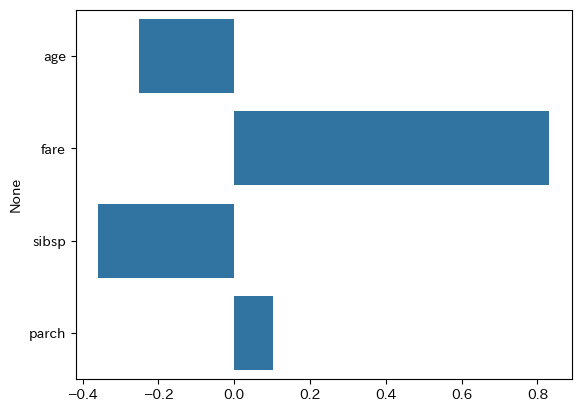

In [19]:
# 回帰係数を可視化
sns.barplot(x=model.coef_[0], y=X.columns)
# plt.show()

## カテゴリ型の項目も追加してモデルを構築

In [20]:
# カテゴリ変数をOne Hot Encoding
data_encoded = pd.get_dummies(data[['embarked', 'class', 'who', 'adult_male', 'alone']], drop_first=True)

# 説明変数と目的変数を設定
X = pd.concat([data[['age', 'fare', 'sibsp', 'parch']], data_encoded], axis=1)
y = data['survived']

In [21]:
# データを学習用データと検証用データに分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 準備のための手順
scaler = StandardScaler()
scaler.fit(X_train)

# 標準化後のものは別の変数にセットすると良い
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

# ロジスティック回帰モデルを作成
model = LogisticRegression()

# モデルを訓練
model.fit(X_train_scaled, y_train)

# テストデータで予測
y_pred = model.predict(X_val_scaled)

# 精度を計算
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8100558659217877


カテゴリ項目を説明変数に加えることで、精度が向上したことが分かる。

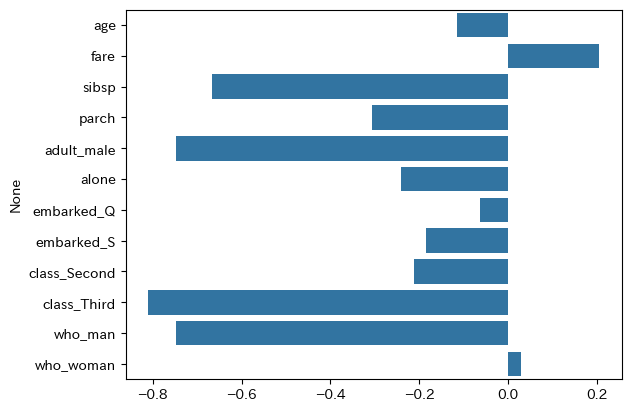

In [22]:
# 回帰係数を可視化
sns.barplot(x=model.coef_[0], y=X.columns)
plt.show()

## ハイパーパラメータチューニング

## 正則化パラメータ

ロジスティック回帰モデルには、
「正則化パラメータ」と呼ばれる値を設定する必要があり、
準備段階で、例えば以下のように指定する。

```
model = LogisticRegression(C=1.0)
```

C=1.0
の部分を変更することで精度をより向上させることが可能である。


なお、指定を省略した場合には、
デフォルトとして C=1.0 が指定される。


正則化パラメータとして、どの値が適切かを調べるために
**グリッドサーチ**と呼ばれる方法がある。

まず、正則化パラメータの候補を、
例えば、以下のように辞書型の変数を設定する。

```
param_grid = {'C': [ 0.1, 0.15, 0.2, 0.3, 1, 2]}
```
正則化パラメータの候補は正の値で、
多くの場合は 0.1 ～ 100の範囲とすると良いことが知られている。

このように設定した候補の中から、
最も良いハイパーパラメータを選び出す方法を**グリッドサーチ**と呼び、
そためのモジュールが用意されている。

モジュールは、以下のようにインポートする。
```
from sklearn.model_selection import GridSearchCV
```

候補を設定したら、GridSearchCV を以下のように初期化し、
その後 fit() で計算を実行する。

```
#グリッドサーチの準備
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)

#グリッドサーチの実行
grid_search.fit(X_train_scaled, y_train.values.ravel() )
```

実行した結果、最適なハイパーパラメータのモデルは以下の変数に格納される。
```
grid_search.best_estimator_
```

In [23]:
# 必要なライブラリをインポート
from sklearn.model_selection import GridSearchCV

# パラメータグリッドを設定
param_grid = {'C': [ 0.1, 0.15, 0.2, 0.3, 0.5]}

# GridSearchCVを初期化
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)

# グリッドサーチを実行
grid_search.fit(X_train_scaled, y_train.values.ravel() )

# 最適なハイパーパラメータのモデルでテストデータを評価
best_model = grid_search.best_estimator_
best_model.fit(X_train_scaled, y_train.values.ravel() )

y_pred = best_model.predict(X_val_scaled)
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation set accuracy: {accuracy}")


Validation set accuracy: 0.8156424581005587


grid_search.best_params_ には、最適なパラメータが格納されている。

In [24]:
# 最適なパラメータとスコアを出力
print(f"Best parameters: {grid_search.best_params_}")
# print(f"Best cross-validation score: {grid_search.best_score_}")

Best parameters: {'C': 0.15}


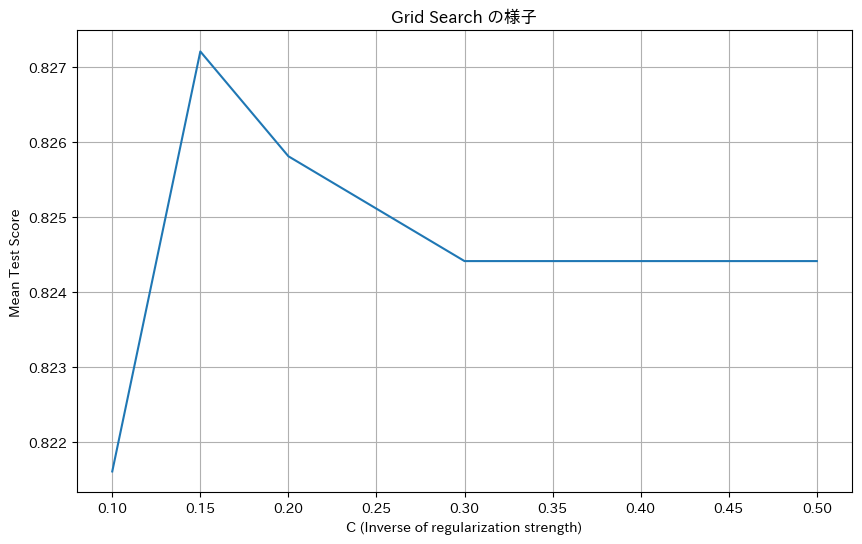

In [25]:
#@title グリッドサーチの内部処理
scores = grid_search.cv_results_['mean_test_score']
plt.figure(figsize=(10, 6))
sns.lineplot(x=param_grid['C'], y=scores)
plt.xlabel('C (Inverse of regularization strength)')
plt.ylabel('Mean Test Score')
plt.title('Grid Search の様子')
plt.grid(True)
plt.show()

---
---
---


# 回帰モデルに対するハイパーパラメータの調整


回帰モデルに対してもハイパーパラメータチューニングを行い精度の向上を図ることが可能である。
ここでは、Ridge 回帰と呼ばれる方法を使い、
ハイパーパラメータチューニングを行う。

## Tipsデータ

ここでは Tipsデータを用いて説明を行う。
Tips データは、
seaborn パッケージに含まれているデモデータで、
以下のコードセルを実行することで
変数 df_tips に読み込まれる。

In [26]:
from seaborn import load_dataset
# データの読み込み
df_tips = sns.load_dataset('tips')

Tipsデータの概要を info で確認する。

In [27]:
df_tips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  244 non-null    float64 
 1   tip         244 non-null    float64 
 2   sex         244 non-null    category
 3   smoker      244 non-null    category
 4   day         244 non-null    category
 5   time        244 non-null    category
 6   size        244 non-null    int64   
dtypes: category(4), float64(2), int64(1)
memory usage: 7.4 KB


### データの説明
このデータは、あるレストランでのチップ金額（tip）のデータである。

主な項目は以下の通り。

項目 | 型 | 説明
-- | -- | --
total_bill | 数値 | 食事代の総額
tip        | 数値 | チップの額
sex        | カテゴリ | 性別
smoker     | カテゴリ | 喫煙者かどうか
day        | カテゴリ | 曜日
time       | カテゴリ | 時間帯が昼か夜か
size       | 数値 | 顧客サイズ（グループの人数）


このデータを使い、チップ金額を予測する回帰モデルを作ってみる。
すなわち

* 目的変数：チップ金額（tip）
* 説明変数：食事代の総額（total_bill）、グループの人数（size）、性別（sex）、など

である。

データの先頭を表示する。

In [28]:
# データの先頭を表示して確認
df_tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


## 分析用データの準備

データの準備として、以下の処理を行う。


*   カテゴリ項目を One-Hot エンコーディング を使い数値型の項目変換
*   変数の標準化

以下のコードセルを実行することで、標準化した説明変数が
X_trans にセットされる。

In [29]:
# 標準化に必要なライブラリーのインポート
from sklearn.preprocessing import StandardScaler

# データの読み込み
df_tips = sns.load_dataset('tips')

# カテゴリ変数をOne-Hotエンコーディング
encoded_df_tips = pd.get_dummies(df_tips[['sex', 'smoker', 'day', 'time']])

# エンコードされたデータと元のデータを結合
df_tips = pd.concat([df_tips, encoded_df_tips], axis=1)

# 説明変数 X と 目的変数 y をセットする
X = df_tips[['total_bill', 'size', 'sex_Male', 'sex_Female', 'smoker_Yes', 'smoker_No', 'day_Thur', 'day_Fri', 'day_Sat', 'day_Sun', 'time_Lunch', 'time_Dinner']]
y = df_tips['tip']

# 標準化の実施
scaler = StandardScaler()
scaler.fit(X)
# 標準化後のデータを X_trans
X_trans = scaler.transform(X)


### Ridge 回帰

回帰モデルの一つである Ridge 回帰を使い、
ハイパーパラメータチューニングを行う。

Ridge 回帰には、「正則化パラメータ」があり、
例えば、以下のように指定する。
```
model = Ridge( alpha =1.0 )
```
alpha に様々な数値を設定することで精度をより向上させることが可能である。

以下のコードセルで、
正則化パラメータ―を変化させると、精度が変化することを確認せよ。


In [30]:
# 必要なライブラリをインポート
from sklearn.linear_model import Ridge

# データを学習データと検証データに分割
X_train, X_validate, y_train, y_validate = train_test_split(X_trans, y, test_size=0.2, random_state=42)

model = Ridge(alpha=10)
model.fit(X_train, y_train.values.ravel() )

# 評価データで精度を確認する
y_pred = model.predict(X_validate)
# 決定係数による評価（R2）
r2 = r2_score(y_validate, y_pred)
print('R2: ', r2)

R2:  0.4438763400753394


RidgeCV というモジュールを用いることで、
以下のような簡潔なコードでハイパーパラメータチューニングを行うことが可能である。


In [31]:
from sklearn.linear_model import RidgeCV

# データを学習データと検証データに分割
X_train, X_validate, y_train, y_validate = train_test_split(X_trans, y, test_size=0.2, random_state=42)

model = RidgeCV()
model.fit(X_train, y_train)

# 評価データで精度を確認する
# 決定係数による評価（R2）
r2 = model.score(X_validate, y_validate)
print('R2: ', r2)

R2:  0.4438763400753437


リッジ回帰をさらに複雑化した回帰手法に、
エラスティックネット（ElasticNet）がある。
以下のように使う。

In [32]:
from sklearn.linear_model import ElasticNetCV

# データを学習データと検証データに分割
X_train, X_validate, y_train, y_validate = train_test_split(X_trans, y, test_size=0.2, random_state=42)

model = ElasticNetCV()
model.fit(X_train, y_train)

# 評価データで精度を確認する
# 決定係数による評価（R2）
r2 = model.score(X_validate, y_validate)
print('R2: ', r2)

R2:  0.48587145263694775


この例では、さらに精度の高いモデルが構築できた。



In [33]:
from sklearn.linear_model import ElasticNetCV

# 標準化に必要なライブラリーのインポート
from sklearn.preprocessing import StandardScaler

# データの読み込み
df_tips = sns.load_dataset('tips')

# 説明変数 X と 目的変数 y をセットする
X = df_tips[['total_bill', 'size']]
y = df_tips['tip']

# 標準化の実施
scaler = StandardScaler()
scaler.fit(X)
# 標準化後のデータを X_trans
X_trans = scaler.transform(X)

# データを学習データと検証データに分割
X_train, X_validate, y_train, y_validate = train_test_split(X_trans, y, test_size=0.2, random_state=42)

model = ElasticNetCV()
model.fit(X_train, y_train)

# 評価データで精度を確認する
# 決定係数による評価（R2）
r2 = model.score(X_validate, y_validate)
print('R2: ', r2)

R2:  0.4898823132152599


## その他の回帰モデル

回帰モデルには、ここでは扱わなかった多くのモデルがある。
各自で以下のサイトを参照し、実際に使ってみる。

https://scikit-learn.org/1.5/api/sklearn.linear_model.html

# その他の参考となるサイト

インターネット上には、様々なデータが公開されている。
各自で予測モデル構築に取り組んでみる。

* https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package

* https://www.kaggle.com/datasets/yeanzc/telco-customer-churn-ibm-dataset


---
---
---

#小テスト解答

Accuracy: 0.691358024691358
[[-0.30508754  0.93077128 -0.35135196  0.0882699 ]]


<Axes: ylabel='None'>

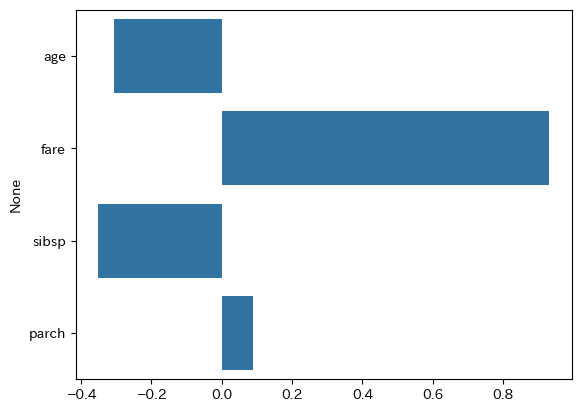

In [65]:
# データを読み込む
# 変数名を data とした
data = sns.load_dataset('titanic') #タイタニックのデータ

# age, embarked, の欠損値を埋める。
# deck は欠損値が多数あるため説明変数には用いないことにする。

# age は数値型なので、平均値で欠損値を埋める。
data['age'] = data['age'].fillna(data['age'].mean())

# カテゴリ型の項目は、最頻値で欠損値を埋める。
data['embarked'] = data['embarked'].fillna(data['embarked'].mode()[0])
data['embark_town'] = data['embark_town'].fillna(data['embark_town'].mode()[0])

# 説明変数と目的変数を選択
# 数値データのみで予測
X = data[[ 'age', 'fare', 'sibsp', 'parch']]
y = data[['survived']]

# 説明変数の標準化の準備
scaler = StandardScaler()
scaler.fit(X)

# 標準化後のものは別の変数にセットすると良い
X_scaled = scaler.transform(X)

# ロジスティック回帰モデルの準備
model = LogisticRegression(C=100.0)

# モデルを訓練
model.fit(X_scaled, y.values.ravel())

# 訓練データで予測
y_pred = model.predict(X_scaled)

# 精度を計算
accuracy = accuracy_score(y, y_pred)
print(f'Accuracy: {accuracy}')

print(model.coef_)
# 回帰係数を可視化
sns.barplot(x=model.coef_[0], y=X.columns)
# plt.show()

---
---
#おまけ

グリッドサーチを行ってみる

In [66]:
# 必要なライブラリをインポート
from sklearn.model_selection import GridSearchCV

# パラメータグリッドを設定
param_grid = {'C': [ 0.1, 0.15, 0.2, 0.3, 0.5, 1.0, 5.0, 10.0, 50, 100.0]}

# GridSearchCVを初期化
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)

# グリッドサーチを実行
grid_search.fit(X_scaled, y.values.ravel() )

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 0.15, 0.2, 0.3, 0.5, 1.0, 5.0, 10.0, 50,
                               100.0]})

<Axes: ylabel='None'>

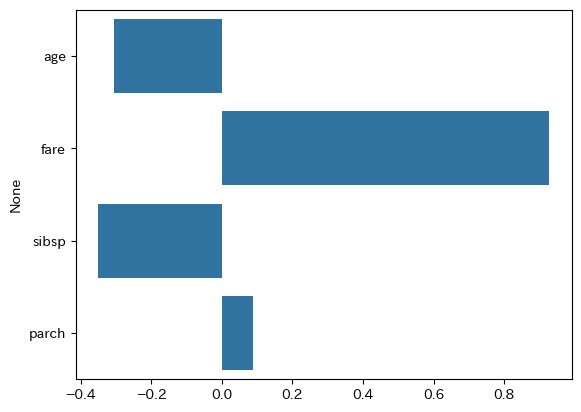

In [69]:
#グリッドサーチの結果（ハイパーパラメータ）を使ってモデルを構築
best_model = grid_search.best_estimator_
best_model.fit(X_scaled, y.values.ravel() )

# 回帰係数を可視化
sns.barplot(x=best_model.coef_[0], y=X.columns)
# plt.show()

#説明変数を増やして学習

In [72]:
# データを読み込む
# 変数名を data とした
data = sns.load_dataset('titanic') #タイタニックのデータ

# age, embarked, の欠損値を埋める。
# deck は欠損値が多数あるため説明変数には用いないことにする。

# age は数値型なので、平均値で欠損値を埋める。
data['age'] = data['age'].fillna(data['age'].mean())

# カテゴリ型の項目は、最頻値で欠損値を埋める。
data['embarked'] = data['embarked'].fillna(data['embarked'].mode()[0])
data['embark_town'] = data['embark_town'].fillna(data['embark_town'].mode()[0])

# カテゴリ変数をOne Hot Encoding
data_encoded = pd.get_dummies(data[['embarked', 'class', 'who', 'adult_male', 'alone']], drop_first=True)

# 説明変数と目的変数を設定
X = pd.concat([data[['age', 'fare', 'sibsp', 'parch']], data_encoded], axis=1)
y = data['survived']

Accuracy: 0.8249158249158249
[[-0.26550452  0.12965869 -0.6982717  -0.30383533 -0.73052865 -0.29746619
  -0.02399539 -0.16137151 -0.38513342 -0.99984961 -0.73052865  0.04162922]]


<Axes: ylabel='None'>

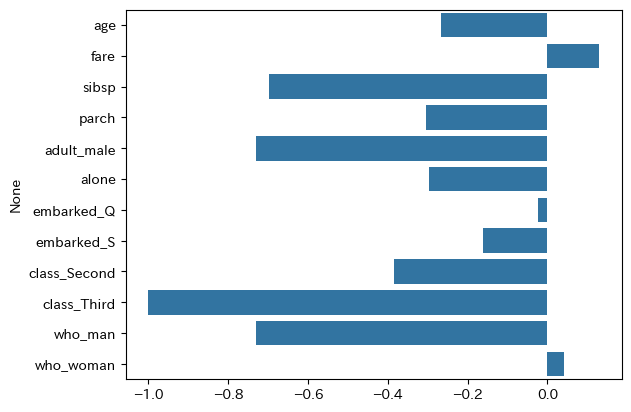

In [73]:
# 標準化の準備
scaler = StandardScaler()
scaler.fit(X)

# 標準化後のものは別の変数にセットすると良い
X_scaled = scaler.transform(X)

# ロジスティック回帰モデルの準備
model = LogisticRegression(C=100.0)

# モデルを訓練
model.fit(X_scaled, y.values.ravel())

# 訓練データで予測
y_pred = model.predict(X_scaled)

# 精度を計算
accuracy = accuracy_score(y, y_pred)
print(f'Accuracy: {accuracy}')

print(model.coef_)
# 回帰係数を可視化
sns.barplot(x=model.coef_[0], y=X.columns)
# plt.show()
